In [1]:
import numpy as np
import netgen.geom2d as geom2d
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.geom2d import SplineGeometry  # SplieGeometry to define a 2D mesh
# visualization stuff
from ngsolve.internal import *
# basic xfem functionality
#from xfem import *
from interpolations import InterpolateLevelSetToElems # function which interpolates a levelset function
import time
myMAXH = 0.1
EPS = myMAXH * 1e-6      #variable defining when a point is on the interface and when not


geo = SplineGeometry()

R = 2

## add a rectangle
geo.AddRectangle(p1=(-R,-R),
                 p2=(R,R),
                 bc="rectangle",
                 leftdomain=1,
                 rightdomain=0)
geo.SetMaterial (1, "outer") # give the domain the name "outer"
mesh = Mesh(geo.GenerateMesh(maxh=myMAXH)) # generate ngsolve mesh


In [2]:
#Spaces and Functions

fes_state = H1(mesh, order=1)
fes_adj = H1(mesh, order=1)
fes_level = H1(mesh, order=1)

pwc = L2(mesh)   #piecewise constant space


## test and trial functions
u, v = fes_state.TnT()

p, q = fes_adj.TnT()

gfu = GridFunction(fes_state)
gfp = GridFunction(fes_adj)

gfud = GridFunction(fes_state)

psi = GridFunction(fes_level)
psi.Set(-1)

psides = GridFunction(fes_level)
psinew = GridFunction(fes_level)

In [3]:
# Forms And Solver
# constants for f_rhs and beta
f1 = 10
f2 = 1

beta1 = 1
beta2 = 1

# piecewise constant coefficient functions beta and f_rhs

beta = GridFunction(pwc)
beta.Set(beta1)

f_rhs = GridFunction(pwc)
f_rhs.Set(f1)

# bilinear form for state equation
B = BilinearForm(fes_state)
B +=grad(u) * grad(v) * dx
B += u *v *dx

B_adj = BilinearForm(fes_adj)
B_adj += grad(p) * grad(q) * dx
B_adj += p * q * dx
L = LinearForm(fes_state)
L += f_rhs * v *dx


# solving
psides.Set(-1)
InterpolateLevelSetToElems(psides, beta1, beta2, beta, mesh, EPS)
InterpolateLevelSetToElems(psides, f1, f2, f_rhs, mesh, EPS)


B.Assemble()
L.Assemble()

inv = B.mat.Inverse( inverse="sparsecholesky") # inverse of bilinear form
gfu.vec.data = inv*L.vec

scene_u = Draw(gfu)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

In [4]:
#Draw(IfPos(psi,-1,1),mesh)

In [5]:
#Define destination function
a = 4.0/5.0
b = 2
f = CoefficientFunction( 0.1*( (sqrt((x - a)**2 + b * y**2) - 1) \
                * (sqrt((x + a)**2 + b * y**2) - 1) \
                * (sqrt(b * x**2 + (y - a)**2) - 1) \
                * (sqrt(b * x**2 + (y + a)**2) - 1) - 0.001) )

psides.Set(f)
InterpolateLevelSetToElems(psides, beta1, beta2, beta, mesh, EPS)
InterpolateLevelSetToElems(psides, f1, f2, f_rhs, mesh, EPS)

B.Assemble()
L.Assemble()
inv = B.mat.Inverse(inverse="sparsecholesky") # inverse of bilinear form

gfud.vec.data = inv*L.vec

Draw(gfud, mesh, 'gfud')

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

In [6]:
def SolvePDE(adjoint=False):
    #Newton(a, gfu, printing = False, maxerr = 3e-9)

    B.Assemble()
    L.Assemble()

    inv_state = B.mat.Inverse(inverse="sparsecholesky")

    # solve state equation
    gfu.vec.data = inv_state*L.vec

    if adjoint == True:
        # solve adjoint state equatoin
        duCost.Assemble()
        B_adj.Assemble()
        inv_adj = B_adj.mat.Inverse(inverse="sparsecholesky")
        gfp.vec.data = -inv_adj * duCost.vec
    scene_u.Redraw()

InterpolateLevelSetToElems(psi, beta1, beta2, beta, mesh, EPS)
InterpolateLevelSetToElems(psi, f1, f2, f_rhs, mesh, EPS)

SolvePDE()

In [7]:
# define the cost function
def Cost(u):
    return (u - gfud+10*x*y)**2*dx

# derivative of cost function
duCost = LinearForm(fes_adj)
duCost += 2*(gfu-gfud+10*x*y) * q * dx
print("initial cost = ", Integrate(Cost(gfu), mesh))

initial cost =  3355.0369878450856


In [8]:
#Topological Derivative

BetaPosNeg = 2 * beta2 * (beta1-beta2)/(beta1+beta2)    # factors in TD in positive part {x: \psi(x)>0} ={x: \beta(x) = \beta_2}
BetaNegPos = 2 * beta1 * (beta1-beta2)/(beta1+beta2)    # factors in TD in 
FPosNeg = -(f1-f2)

psinew.vec.data = psi.vec

## normalise psi in L2
normPsi = sqrt(Integrate(psi**2*dx, mesh))
psi.vec.data = 1/normPsi * psi.vec

# set level set function to data
InterpolateLevelSetToElems(psi, beta1, beta2, beta, mesh, EPS)
InterpolateLevelSetToElems(psi, f1, f2, f_rhs, mesh, EPS)

Redraw()

TD_node = GridFunction(fes_level)
#scene1 = Draw(TD_node, mesh, "TD_node")

TD_pwc = GridFunction(pwc)
#scene2 = Draw(TD_pwc, mesh, "TD_pwc")

TDPosNeg_pwc = GridFunction(pwc)
TDNegPos_pwc = GridFunction(pwc)

cutRatio = GridFunction(pwc)

# solve for current configuration
SolvePDE(adjoint=True)
ell = 120

In [ ]:
iter_max = 50
converged = False
g_k = GridFunction(fes_level)

kappa = 0.1
costs = []
iterations = [] 
thetas = []
active_dofs = []
N = fes_state.ndof

xm=0.
ym=0.
#psi.Set( (x-xm)**2+(y-ym)**2-0.25**2)
psi.Set(-1)
psinew.vec.data= psi.vec
scene_u = Draw(gfu) ##DRAW
scene_psi = Draw(IfPos(psi,1,-1),mesh)
theta_tolerance = 1.5

J = Integrate(Cost(gfu),mesh)

with TaskManager():

    for k in range(iter_max):
        print("================ iteration ", k, "===================")

        # copy new levelset data from psinew into psi
        psi.vec.data = psinew.vec
        scene_psi.Redraw()
        time.sleep(6)


        SolvePDE(adjoint=True)
        scene_u.Redraw()
        #time.sleep(5)
        J_current = Integrate(Cost(gfu),mesh)

        print( Integrate( (gfu-gfud+10*x*y)**2*dx, mesh) )

        print("cost in beginning of iteration", k, ": Cost = ", J_current)

        # compute the piecewise constant topological derivative in each domain
        TDPosNeg_pwc.Set( BetaPosNeg * grad(gfu) * grad(gfp)  + FPosNeg*gfp )
        TDNegPos_pwc.Set( BetaNegPos * grad(gfu) * grad(gfp)  + FPosNeg*gfp )

        # compute the cut ratio of the interface elements
        InterpolateLevelSetToElems(psi, 1, 0, cutRatio, mesh, EPS)

        # compute the combined topological derivative using the cut ratio information
        for j in range(len(TD_pwc.vec)):
            TD_pwc.vec[j] = cutRatio.vec[j] * TDNegPos_pwc.vec[j] + (1-cutRatio.vec[j])*TDPosNeg_pwc.vec[j]

        TD_node.Set(TD_pwc)
        indices = []  

        for i in range(len(TD_node.vec)):
            if psi.vec[i] < 0 and TD_node.vec[i] > 0:
                indices.append(i)
            elif psi.vec[i] > 0 and TD_node.vec[i] < 0:
                indices.append(i)

        active_dofs.append(len(indices))
        iterations.append(k)
        print("Non optimals =" ,len(indices),"out of", N)

        if (len(indices) < int(0.005*N)) and (k > 4) :
            print("99.5% of elements satisfy optimality conditions, non optimal elements are",len(indices) ," out of ",N )
            break
            
        normTD = sqrt(Integrate(TD_node**2*dx, mesh)) # L2 norm of TD_node

        normPsi = sqrt(Integrate(psi**2*dx, mesh)) # L2 norm of psi

        arg_arc = Integrate(psi*TD_node,mesh)/(normTD*normPsi)
        theta_k = np.arccos(arg_arc)*180/np.pi
        print("Theta_k =",theta_k,"  degrees")
        thetas.append(theta_k)

        # if theta_k < theta_tolerance:
        #     print("Theta Converged, theta = ", theta_k,"    degrees")
        #     break

        const_gk = Integrate(psi*TD_node,mesh)/(normPsi**2)
        g_k.Set( -1*(TD_node-const_gk*psi)   )
        TD_node.vec.data = 1/normTD * TD_node.vec # normalised TD_node
        psi.vec.data = 1/normPsi * psi.vec  # normalised psi

        
        linesearch = True

        for j in range(10):

            # update the level set function
            psinew.vec.data = (1-kappa)*psi.vec + kappa*TD_node.vec
          #  psinew.vec.data = psi.vec - kappa *g_k.vec

            # update beta and f_rhs
            InterpolateLevelSetToElems(psinew, beta1, beta2, beta, mesh, EPS)
            InterpolateLevelSetToElems(psinew, f1, f2, f_rhs, mesh, EPS)

            # solve PDE without adjoint
            SolvePDE()

            Redraw(blocking=True)

            Jnew = Integrate(Cost(gfu), mesh)

            if Jnew > J_current:
                print("--------------------")
                print("-----line search ---")
                print("--------------------")
                kappa = kappa*0.8
                print("kappa", kappa)
            else:
                kappa = 1.2*kappa
                break

        Redraw(blocking=True)
        print("----------- Jnew in  iteration ", k, " = ", Jnew, " (kappa = ", kappa, ")")
        print('')
        print("iter" + str(k) + ", Jnew = " + str(Jnew) + " (kappa = ", kappa, ")")
        kappa = min(1, kappa*1.2)

        print("end of iter " + str(k))

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

================ iteration  0 ===================
2239.976729581744
cost in beginning of iteration 0 : Cost =  2239.976729581744
Non optimals = 1051 out of 1942
Theta_k = 97.15607233176097   degrees
--------------------
-----line search ---
--------------------
kappa 0.08000000000000002
--------------------
-----line search ---
--------------------
kappa 0.06400000000000002
--------------------
-----line search ---
--------------------
kappa 0.051200000000000016
--------------------
-----line search ---
--------------------
kappa 0.04096000000000002
--------------------
-----line search ---
--------------------
kappa 0.03276800000000001
--------------------
-----line search ---
--------------------
kappa 0.026214400000000013
--------------------
-----line search ---
--------------------
kappa 0.02097152000000001
--------------------
-----line search ---
--------------------
kappa 0.016777216000000008
--------------------
-----line search ---
--------------------
kappa 0.013421772800000

In [10]:
print(len(indices))

8


In [11]:
import csv

# Save data to CSV
with open('Non_opt_pnts_REF10xy.csv', 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['Iterations', 'Non-Optimal Points'])
    for i in range(len(iterations)):
        csvwriter.writerow([iterations[i], active_dofs[i]])

print("Data saved to data.csv")

Data saved to data.csv


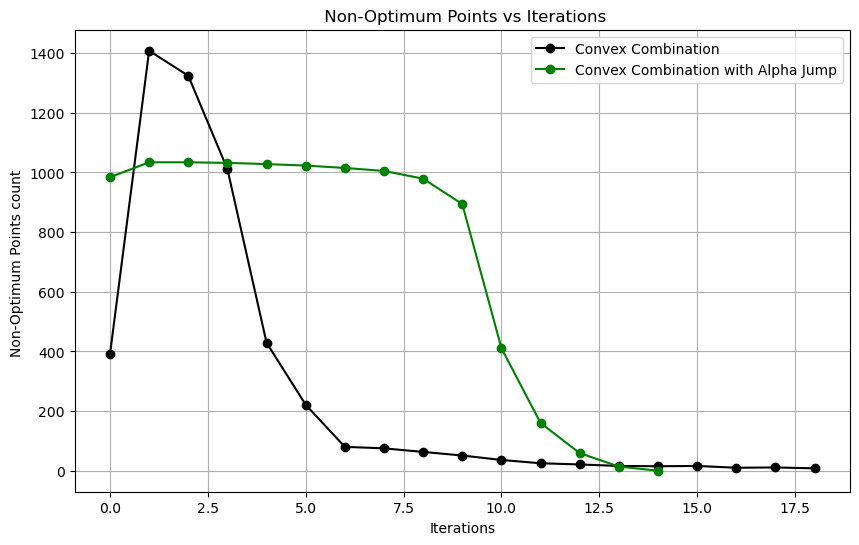

In [17]:
import csv
import matplotlib.pyplot as plt

# Function to read data from CSV
def read_csv(filename):
    iterations = []
    non_opts = []
    with open(filename, 'r') as csvfile:
        csvreader = csv.reader(csvfile)
        next(csvreader)  # Skip header row
        for row in csvreader:
           iterations.append(int(row[0]))
           non_opts.append(float(row[1]))
    return iterations, non_opts

# Read data from the first CSV file
# iterations1, non_opts1 = read_csv('Non_opt_pnts.csv')
# iterations2, non_opts2 = read_csv('Non_opt_pnts_alpha12.csv')
iterations3, non_opts3 = read_csv('Non_opt_pnts_REF10xy.csv')
iterations4, non_opts4 = read_csv('Non_opt_pnts_REF_alpha12_convex_comb.csv')


# Read data from the second CSV file
#iterations2, nonoptimal_points2 = read_csv('Non_opt_pnts_xy.csv')

# iterations3, nonoptimal_points3 = read_csv('Non_opt_pnts_alpha12_convex_comb.csv')
# iterations4, nonoptimal_points4 = read_csv('Non_opt_pnts_REF10xy.csv')
# iterations5, nonoptimal_points5 = read_csv('Non_opt_pnts_REF_alpha12.csv')


#Sort data
# sorted_data1 = sorted(zip(iterations1, non_opts1 ))
# iterations1, non_opts1  = zip(*sorted_data1)

# sorted_data2 = sorted(zip(iterations2, non_opts2))
# iterations2, non_opts2  = zip(*sorted_data2)

sorted_data3 = sorted(zip(iterations3, non_opts3))
iterations3, non_opts3  = zip(*sorted_data3)

sorted_data4 = sorted(zip(iterations4, non_opts4 ))
iterations4, non_opts4  = zip(*sorted_data4)

# Create the plot
plt.figure(figsize=(10, 6))
# plt.plot(iterations1, non_opts1 , marker='o', linestyle='-', color='r', label='Lagrange Newton ')
# plt.plot(iterations2,  non_opts2 , marker='o', linestyle='-', color='b', label='Lagrange Newton with Alpha Jump')
plt.plot(iterations3,  non_opts3 , marker='o', linestyle='-', color='k', label='Convex Combination ')
plt.plot(iterations4,  non_opts4 , marker='o', linestyle='-', color='g', label='Convex Combination with Alpha Jump')

# plt.plot(iterations2, nonoptimal_points2, marker='s', linestyle='--', color='r', label='xy')
# plt.plot(iterations3, nonoptimal_points3, marker='*', linestyle=':', color='m', label='10xy with alpha12 jump')
# plt.plot(iterations4, nonoptimal_points4, marker='x', linestyle='-', color='m', label='10xy with projected grad')
# plt.plot(iterations5, nonoptimal_points5, marker='o', linestyle='-', color='k', label='10xy,alpha12(2,7) with projected grad')



# Add titles and labels
plt.title(' Non-Optimum Points vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('Non-Optimum Points count ')

# Show the legend
plt.legend()

# Show the grid
plt.grid(True)
plt.savefig("NonOptimalPoints.png")
# Display the plot
plt.show()
